In [45]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import cheby1, freqz

from Functions.daub_5_3_lift import daub_5_3_lift
from Functions.idaub_5_3_lift import idaub_5_3_lift
from Functions.daub_5_3_lift_2D import daub_5_3_lift_2D
from Functions.idaub_5_3_lift_2D import idaub_5_3_lift_2D

Настройки форматирования графиков.

In [46]:
user_figsize = (12,6)
user_frqsize = (12,8)
user_fontsize = 14
user_ylabel = ['Magnitude, db', 'Phase, deg']

Параметры измерителя частотных характеристик.

In [47]:
# Частота и период дискретизации.
F_SAMPLE = 102400
T_SAMPLE = 1/F_SAMPLE

# Наименьшая частота в спектре и окно измерений.
F_LOW = 100
H_WINDOW = 1/F_LOW
N_FFT = int(H_WINDOW/T_SAMPLE+0.5)
print('N_FFT  =', N_FFT)

# Полный интервал измерений кратно превышает окно.
T_FULL = 4*H_WINDOW
N_POINT = int(T_FULL/T_SAMPLE+0.5)
print('N_POINT=', N_POINT)

N_FFT  = 1024
N_POINT= 4096


# Динамический объект
В качестве динамического объекта принят IIR-фильтр.

In [48]:
def IIR_filter(x, b_coeff, a_coeff):
    # Создаем список из нулей.
    y = [0] * len(x)
    for k in range(len(x)):
        for m, b in enumerate(b_coeff):
            if (k-m) >= 0:
                y[k] += b * x[k-m]
        for n, a in enumerate(a_coeff[1:], start=1):
            if (k-n) >= 0:
                y[k] -= a * y[k-n]
    return y

Синтезирован фильтр нижних частот.

In [49]:
# Crossover frequency.
fc = 1e3

filter_order = 2
filter_mag = 5

b, a = cheby1(filter_order, filter_mag, fc/(F_SAMPLE/2), btype='low')

Частотная характеристика синтезированного фильтра

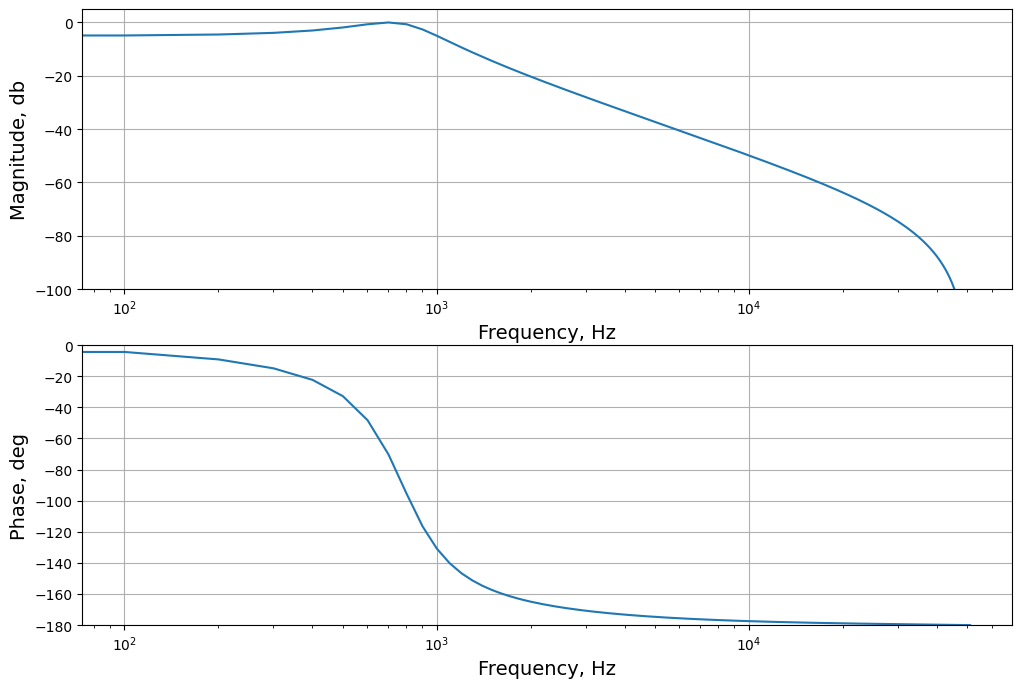

In [50]:
freq_graph = np.linspace(0, F_SAMPLE/2, N_FFT//2)

_, h = freqz(b, a, worN=N_FFT//2)
filter_abs_phase = [20*np.log10(np.abs(h)), np.unwrap(np.angle(h))*180/np.pi]

user_ylim = [[-100, 5], [-180, 0]]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frqsize)
for ax, plot_var, ylim, ylable in zip(axes, filter_abs_phase, user_ylim, user_ylabel):
    ax.plot(freq_graph, plot_var)
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.grid(True)
plt.show()

# Измерение частотных характеристик
Массив инжектируемых частот.

In [51]:
N_FREQ = int(F_SAMPLE/2/F_LOW) - 1
freq = np.linspace(F_LOW, F_SAMPLE/2-F_LOW, N_FREQ)
print('Количество частот:', N_FREQ)

Количество частот: 511


Набор сигналов инжекции.

In [52]:
# Параметры сигнала.
Xm = 3
phi_x = np.pi/6
NOISE_MAG = 0.01 * Xm

# Независимая и зависимая переменные.
t = np.linspace(0, T_FULL-T_SAMPLE, N_POINT)
x_full = np.empty((N_FREQ,), dtype=object)
for k, f in enumerate(freq):
    x_full[k] = Xm * np.cos(2*np.pi*f*t + phi_x) + np.random.normal(0, NOISE_MAG, N_POINT)

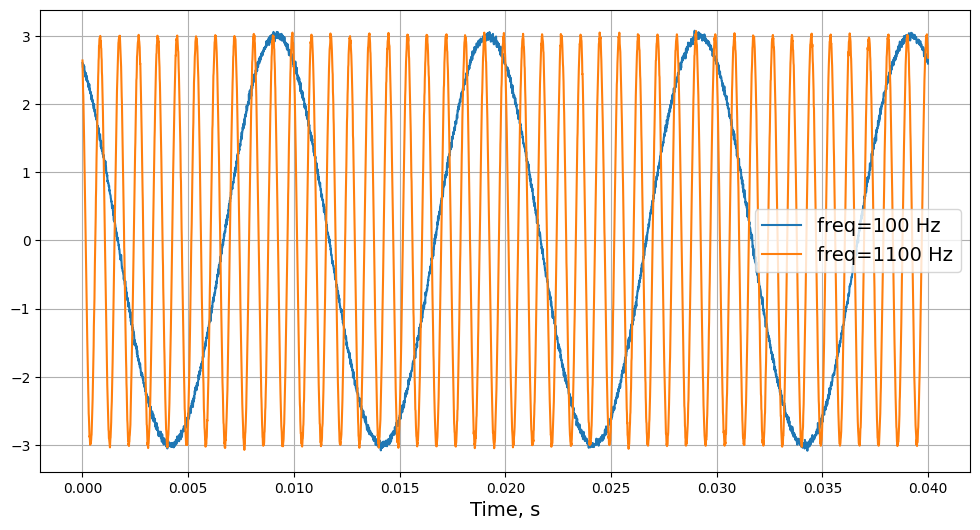

In [53]:
plt.figure(figsize=user_figsize)
plt.plot(t,x_full[0], label='freq='+str(int(freq[0]))+' Hz')
plt.plot(t,x_full[10], label='freq='+str(int(freq[10]))+' Hz')
plt.xlabel('Time, s', fontsize=user_fontsize)
plt.grid()
plt.legend(fontsize=user_fontsize)
plt.show()

Выходной сигнал системы.

In [54]:
y_full = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x_full):
    y_full[k] = IIR_filter(xf, b, a)

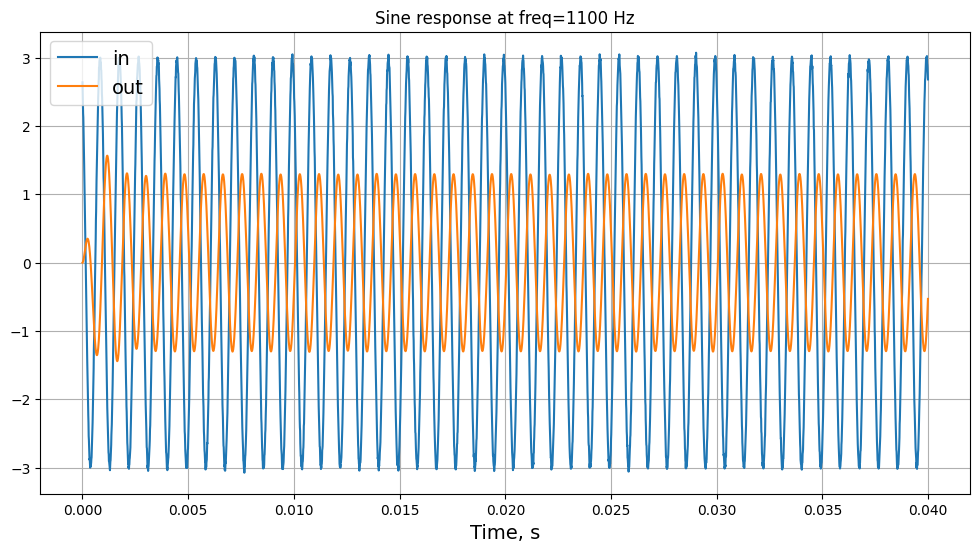

In [55]:
N_TEST = 10

plt.figure(figsize=user_figsize)
plt.plot(t, x_full[N_TEST], label='in')
plt.plot(t, y_full[N_TEST], label='out')
plt.title('Sine response at freq='+str(int(freq[N_TEST]))+' Hz')
plt.xlabel('Time, s', fontsize=user_fontsize)
plt.grid()
plt.legend(fontsize=user_fontsize)
plt.show()

Последние N_FFT-значений приняты в качестве установившихся и использованы в Фурье-анализе.

In [56]:
x = np.empty((N_FREQ,), dtype=object)
y = np.empty((N_FREQ,), dtype=object)
for k in range(N_FREQ):
    x[k] = x_full[k][-N_FFT:]
    y[k] = y_full[k][-N_FFT:]

Частотная характеристика

In [57]:
def freq_resp(x, y):
    N_FREQ = len(x)
    complex_gain = np.zeros((N_FREQ,), dtype=complex)

    for k in range(N_FREQ):
        Xfft = np.fft.rfft(x[k])
        Yfft = np.fft.rfft(y[k])
        complex_gain[k] = Yfft[k+1]/Xfft[k+1]
    return complex_gain

In [58]:
complex_gain_ideal = freq_resp(x, y)
gain_abs_arg_ideal = [20*np.log10(np.abs(complex_gain_ideal)), np.unwrap(np.angle(complex_gain_ideal))*180/np.pi]

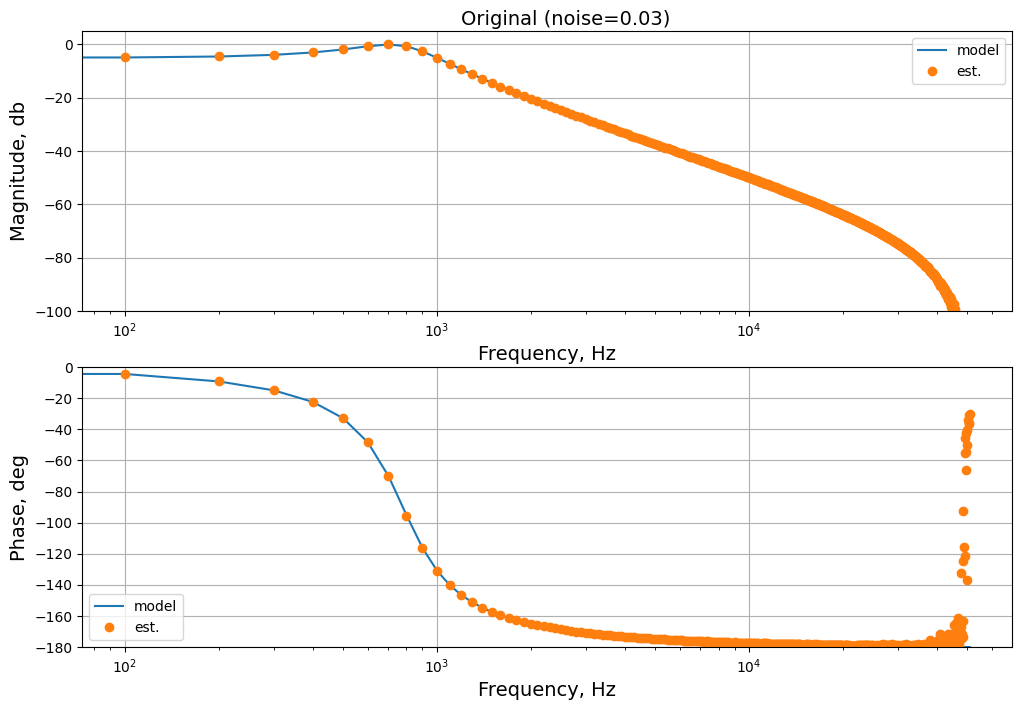

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frqsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_ideal):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Original (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

## Децимация
Каждая 2-я точка удалена.

In [60]:
x_decim = np.empty((N_FREQ//2,), dtype=object)
y_decim = np.empty((N_FREQ//2,), dtype=object)

for k in range(N_FREQ//2):
    x_decim[k] = np.zeros((len(x[k])//2,))
    y_decim[k] = np.zeros((len(y[k])//2,))
    x_decim[k] = x[k][::2]
    y_decim[k] = y[k][::2]

x-length= 512
y-length= 512


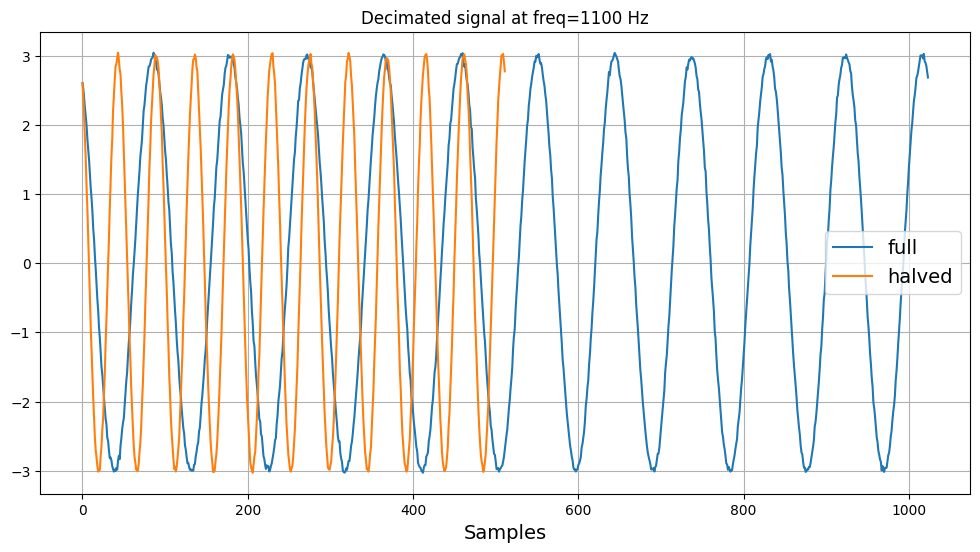

In [61]:
print('x-length=', len(x_decim[N_TEST]))
print('y-length=', len(y_decim[N_TEST]))

plt.figure(figsize=user_figsize)
plt.plot(x[N_TEST], label='full')
plt.plot(x_decim[N_TEST], label='halved')
plt.title('Decimated signal at freq='+str(int(freq[N_TEST]))+' Hz')
plt.xlabel('Samples', fontsize=user_fontsize)
plt.grid()
plt.legend(fontsize=user_fontsize)
plt.show()

In [62]:
complex_gain_decim = freq_resp(x_decim, y_decim)
gain_abs_arg_decim = [20*np.log10(np.abs(complex_gain_decim)), np.unwrap(np.angle(complex_gain_decim))*180/np.pi]

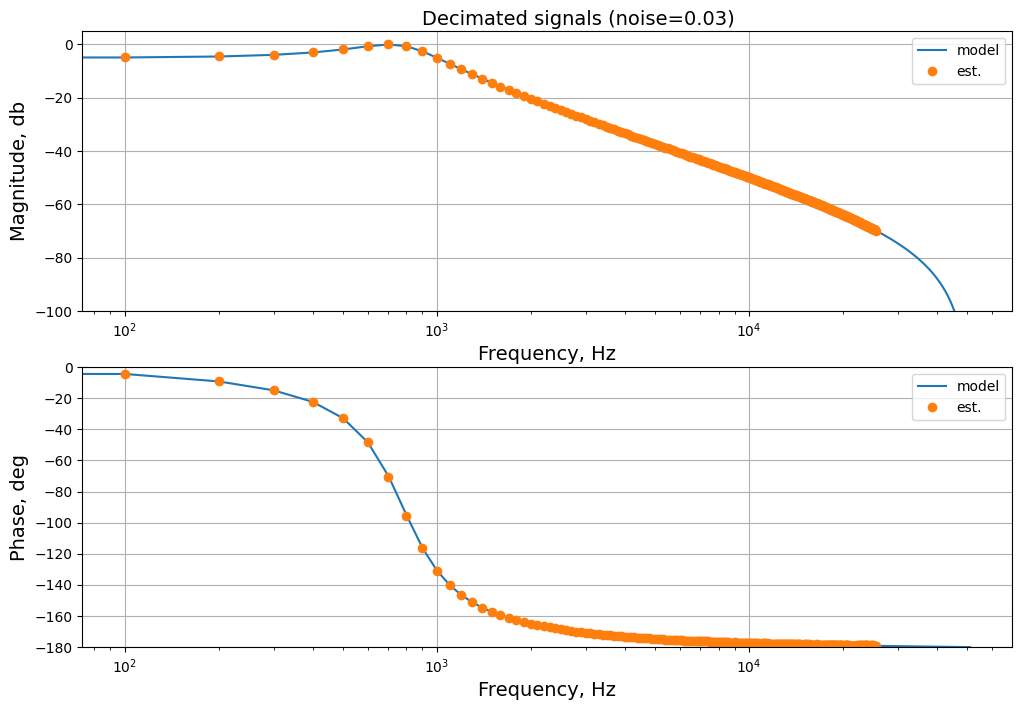

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frqsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_decim):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq[:N_FREQ//2], gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(900, 220, 'Decimated signals (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

## Заполнение нулями
Каждая 2-я точка обнулена.

In [64]:
x_deczero = np.empty((N_FREQ,), dtype=object)
y_deczero = np.empty((N_FREQ,), dtype=object)

for k in range(N_FREQ):
    x_deczero[k] = np.zeros_like(x[k])
    y_deczero[k] = np.zeros_like(y[k])
    x_deczero[k][::2] = x[k][::2]
    y_deczero[k][::2] = y[k][::2]

x-length= 1024
y-length= 1024


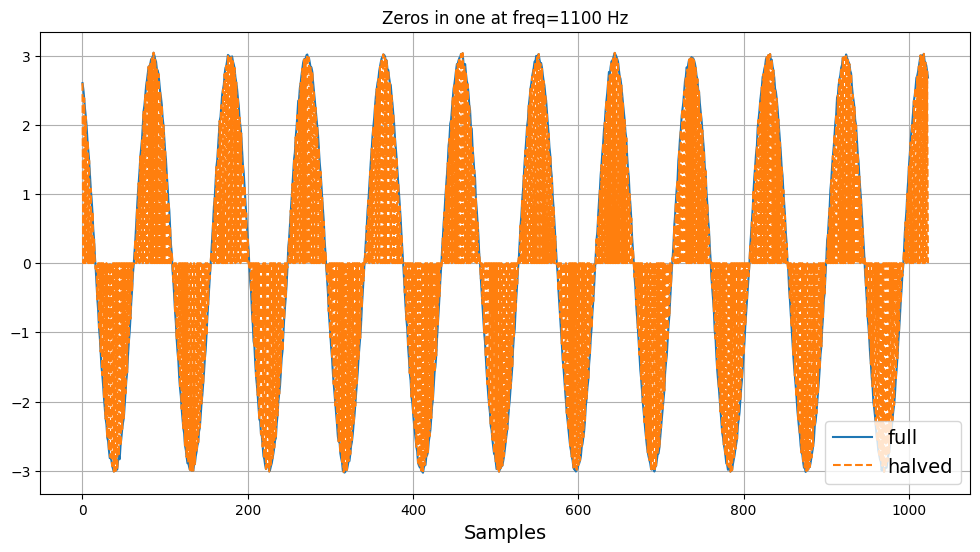

In [65]:
print('x-length=', len(x_deczero[N_TEST]))
print('y-length=', len(y_deczero[N_TEST]))

plt.figure(figsize=user_figsize)
plt.plot(x[N_TEST], label='full')
plt.plot(x_deczero[N_TEST], '--', label='halved')
plt.title('Zeros in one at freq='+str(int(freq[N_TEST]))+' Hz')
plt.xlabel('Samples', fontsize=user_fontsize)
plt.grid()
plt.legend(fontsize=user_fontsize)
plt.show()

In [66]:
complex_gain_deczero = freq_resp(x_deczero, y_deczero)
gain_abs_arg_deczero = [20*np.log10(np.abs(complex_gain_deczero)), np.unwrap(np.angle(complex_gain_deczero))*180/np.pi]

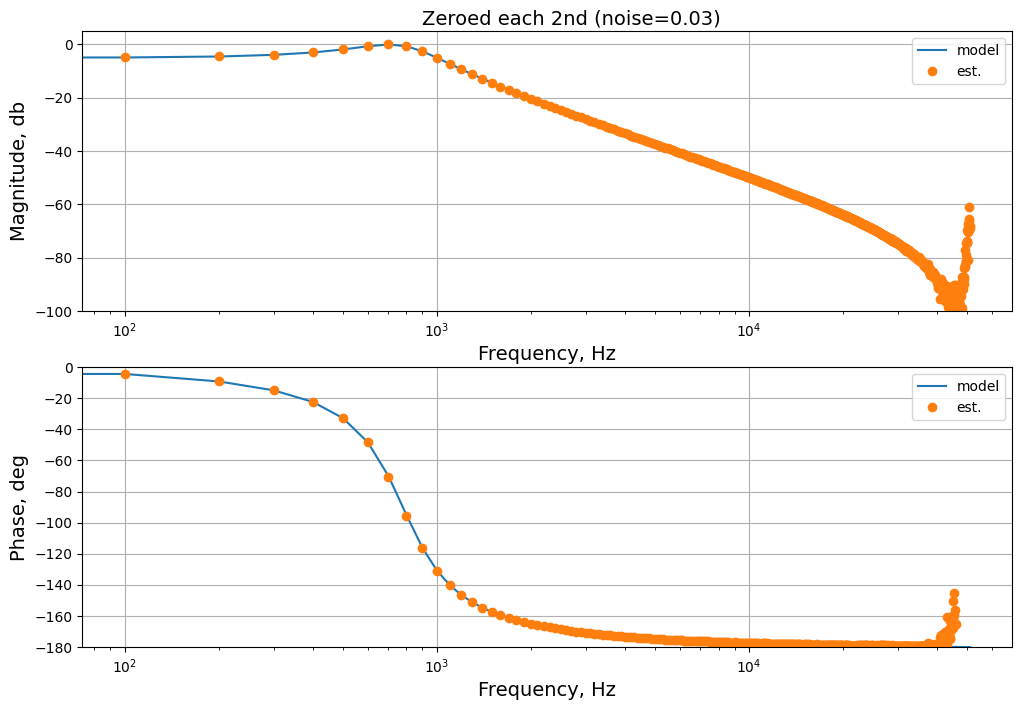

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frqsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_deczero):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(900, 220, 'Zeroed each 2nd (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

## Линейная интерполяция
Соседние точки соединяем отрезком прямой.

In [68]:
x_decinterp = np.empty((N_FREQ,), dtype=object)
y_decinterp = np.empty((N_FREQ,), dtype=object)

for k in range(N_FREQ):
    x_decinterp[k] = np.zeros_like(x[k])
    y_decinterp[k] = np.zeros_like(y[k])
    x_decinterp[k][::2] = x[k][::2]
    y_decinterp[k][::2] = y[k][::2]
    for n in range(1, N_FFT//2):
        x_decinterp[k][2*n-1] = (x_decinterp[k][2*n-2]+x_decinterp[k][2*n])/2
    x_decinterp[k][-1] = x_decinterp[k][-2]


x-length= 1024
y-length= 1024


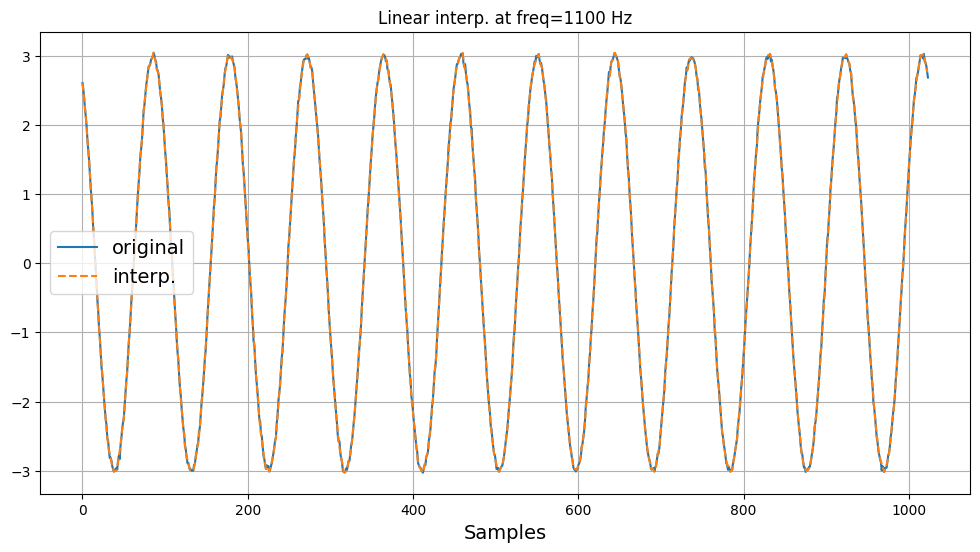

In [69]:
print('x-length=', len(x_decinterp[N_TEST]))
print('y-length=', len(y_decinterp[N_TEST]))

plt.figure(figsize=user_figsize)
plt.plot(x[N_TEST], label='original')
plt.plot(x_decinterp[N_TEST], '--', label='interp.')
plt.title('Linear interp. at freq='+str(int(freq[N_TEST]))+' Hz')
plt.xlabel('Samples', fontsize=user_fontsize)
plt.grid()
plt.legend(fontsize=user_fontsize)
plt.show()

In [70]:
complex_gain_decinterp = freq_resp(x_decinterp, y_decinterp)
gain_abs_arg_decinterp = [20*np.log10(np.abs(complex_gain_decinterp)), np.unwrap(np.angle(complex_gain_decinterp))*180/np.pi]

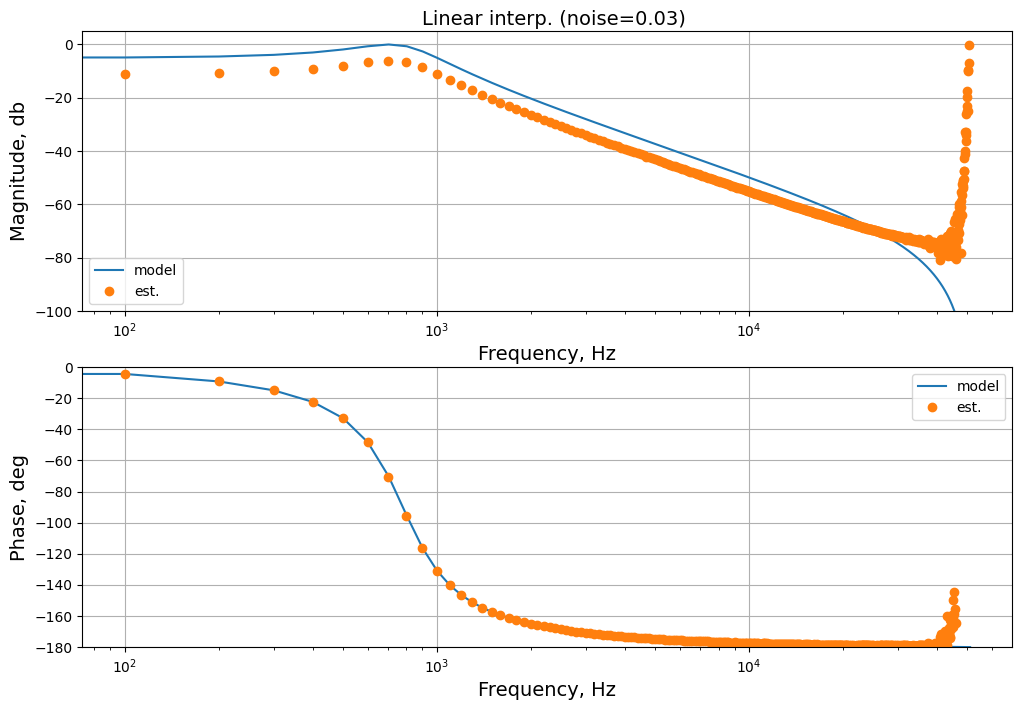

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frqsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_decinterp):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(900, 220, 'Linear interp. (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

# Компрессия

## 1D-компрессия

In [ ]:
x_compr = np.empty((N_FREQ,), dtype=object)
y_compr = np.empty((N_FREQ,), dtype=object)

for k, xf in enumerate(x):
    x_coeff = daub_5_3_lift(xf[-N_FFT:], int_flag=False)
    x_coeff[-N_FFT//2:] = 0
    x_compr[k] = idaub_5_3_lift(x_coeff, int_flag=False)

for k, yf in enumerate(y):
    y_coeff = daub_5_3_lift(np.array(yf[-N_FFT:]), int_flag=False)
    y_coeff[-N_FFT//2:] = 0
    y_compr[k] = idaub_5_3_lift(y_coeff, int_flag=False)

complex_gain_compr = freq_resp(x_compr, y_compr, N_FREQ)
gain_abs_arg_compr = [20*np.log10(np.abs(complex_gain_compr)), np.unwrap(np.angle(complex_gain_compr))*180/np.pi]

TypeError: freq_resp() takes 2 positional arguments but 3 were given

In [ ]:
print(np.array(x_compr[0]).shape)

(1024,)


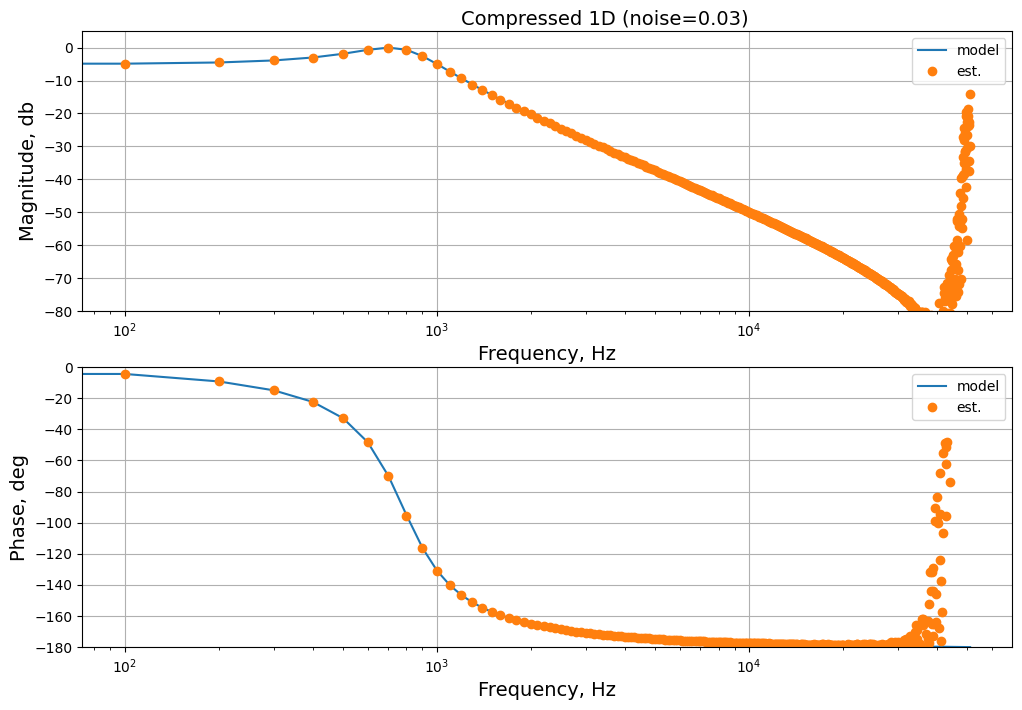

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Compressed 1D (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

Двумерное преобразование

In [ ]:
N_ROW = 32
N_COL = 32

N_FIG = 45

In [ ]:
x_sq = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x):
    x_sq[k] = xf[-N_FFT:].reshape(N_ROW, -1)

y_sq = np.empty((N_FREQ,), dtype=object)
for k, yf in enumerate(y):
    y_sq[k] = np.array(yf[-N_FFT:]).reshape(N_ROW, -1)

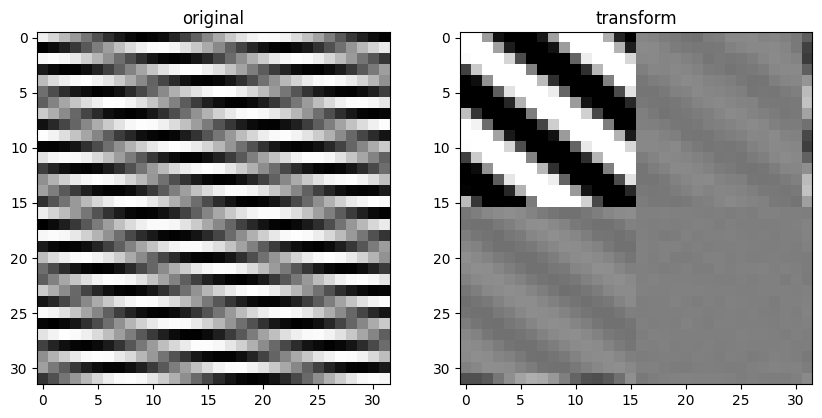

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(x_sq[N_FIG], cmap='gray', interpolation='none', vmin=x_sq[N_FIG].min(), vmax=x_sq[N_FIG].max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(daub_5_3_lift_2D(x_sq[N_FIG], int_flag=False), cmap='gray', interpolation='none', vmin=x_sq[N_FIG].min(), vmax=x_sq[N_FIG].max())
axs.flat[1].set_title('transform')
plt.show()

In [ ]:
x_compr_2D = np.empty((N_FREQ,), dtype=object)
y_compr_2D = np.empty((N_FREQ,), dtype=object)

for k, xf in enumerate(x_sq):
    x_coeff = np.zeros((N_ROW,N_COL))
    x_coeff[:,:N_COL//2] = daub_5_3_lift_2D(xf, int_flag=False)[:,:N_COL//2]
    x_compr_2D[k] = idaub_5_3_lift_2D(x_coeff, int_flag=False).ravel()

for k, yf in enumerate(y_sq):
    y_coeff = np.zeros((N_ROW,N_COL))
    y_coeff[:,:N_COL//2] = daub_5_3_lift_2D(yf, int_flag=False)[:,:N_COL//2]
    y_compr_2D[k] = idaub_5_3_lift_2D(y_coeff, int_flag=False).ravel()

complex_gain_compr_2D = freq_resp(x_compr_2D, y_compr_2D, N_FREQ)
gain_abs_arg_compr_2D = [20*np.log10(np.abs(complex_gain_compr_2D)), np.unwrap(np.angle(complex_gain_compr_2D))*180/np.pi]

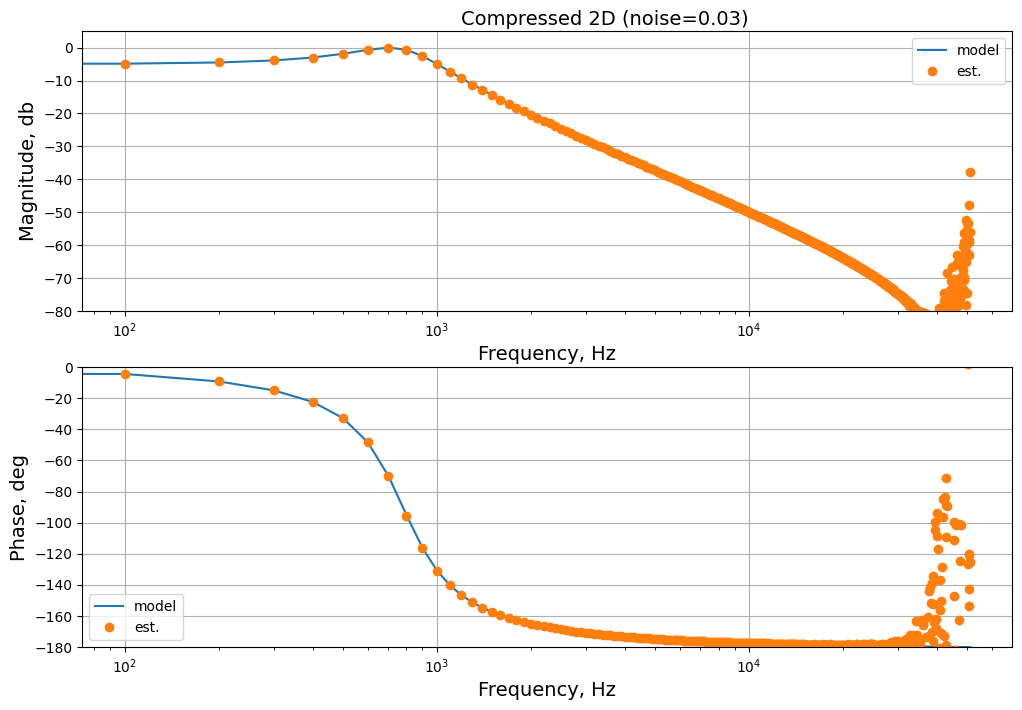

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr_2D):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Compressed 2D (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

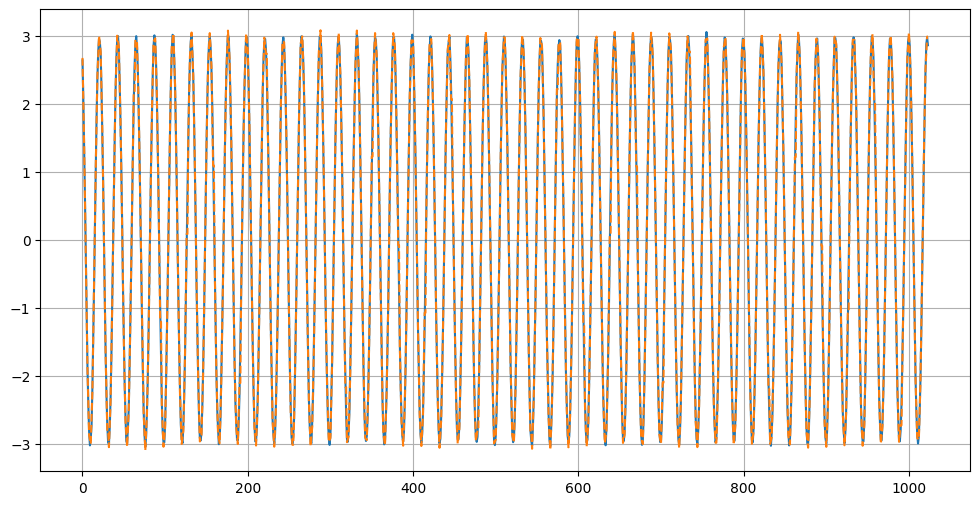

In [ ]:
plt.figure(figsize=user_figsize)
plt.plot(x[N_FIG][-N_FFT:])
plt.plot(x_compr_2D[N_FIG], '--')
plt.grid()
plt.show()

In [ ]:
from Functions.scanorder import zigzag_order
order = zigzag_order(Nrow=N_ROW, Ncol=N_COL, LH_to_RL=False, init_value=0)

In [ ]:
x_compr_2D_zg = np.empty((N_FREQ,), dtype=object)
y_compr_2D_zg = np.empty((N_FREQ,), dtype=object)
x_compr_2D_zg_rev = np.empty((N_FREQ,), dtype=object)
y_compr_2D_zg_rev = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x):
    xf_zigzag = np.zeros_like(order)
    x_coeff   = np.zeros_like(order)
    
    xf_cut = xf[-N_FFT:]
    for m in range(N_COL):
        for n in range(N_ROW):
            xf_zigzag[n,m] = xf_cut[order[n,m]]
    
    x_coeff[-N_ROW//2:,:N_COL//2] = daub_5_3_lift_2D(xf_zigzag, int_flag=False)[-N_ROW//2:,:N_COL//2]
    #x_coeff = daub_5_3_lift_2D(xf_zigzag, int_flag=False)
    
    x_compr_2D_zg[k] = idaub_5_3_lift_2D(x_coeff, int_flag=False)
    
    x_compr_2D_zg_rev[k] = np.zeros_like(xf[-N_FFT:])
    for m in range(N_COL):
        for n in range(N_ROW):
            x_compr_2D_zg_rev[k][order[n,m]] = x_compr_2D_zg[k][n,m]

for k, yf in enumerate(y):
    yf_zigzag = np.zeros((N_ROW,N_COL))
    y_coeff   = np.zeros((N_ROW,N_COL))
    
    yf_cut = yf[-N_FFT:]
    for m in range(N_COL):
        for n in range(N_ROW):
            yf_zigzag[n,m] = yf_cut[order[n,m]]
    
    y_coeff[-N_ROW//2:,:N_COL//2] = daub_5_3_lift_2D(yf_zigzag, int_flag=False)[-N_ROW//2:,:N_COL//2]
    #y_coeff = daub_5_3_lift_2D(yf_zigzag, int_flag=False)
    
    y_compr_2D_zg[k] = idaub_5_3_lift_2D(y_coeff, int_flag=False)
    
    y_compr_2D_zg_rev[k] = np.zeros_like(yf[-N_FFT:])
    for m in range(N_COL):
        for n in range(N_ROW):
            y_compr_2D_zg_rev[k][order[n,m]] = y_compr_2D_zg[k][n,m]

complex_gain_compr_2D_zg = freq_resp(x_compr_2D_zg_rev, y_compr_2D_zg_rev, N_FREQ)
gain_abs_arg_compr_2D_zg = [20*np.log10(np.abs(complex_gain_compr_2D_zg)), np.unwrap(np.angle(complex_gain_compr_2D_zg))*180/np.pi]

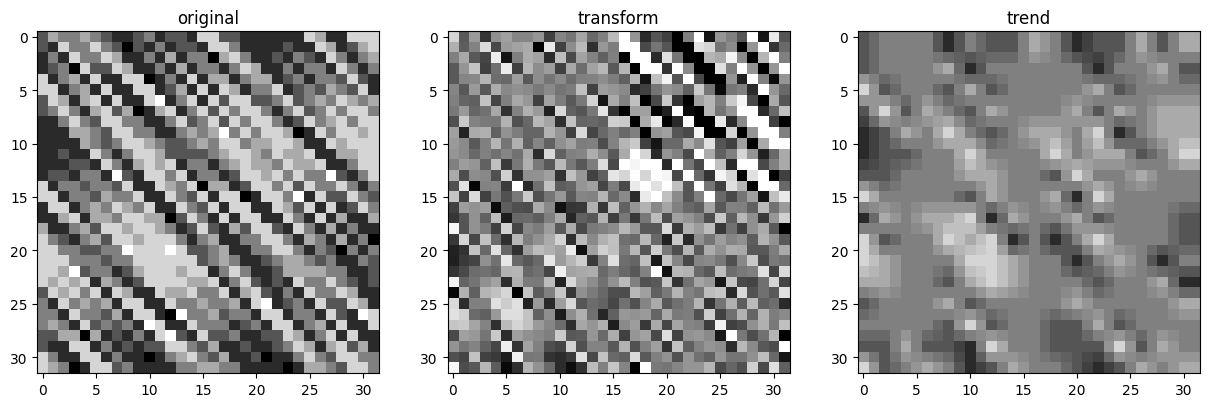

In [ ]:
x_zigzag = np.zeros_like(order)
x_fig = x[N_FIG]
for m in range(N_COL):
    for n in range(N_ROW):
        x_fig_cut = x_fig[-N_FFT:]
        x_zigzag[n,m] = x_fig_cut[order[n,m]]

coeff_zigzag = daub_5_3_lift_2D(x_zigzag, int_flag=False)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
axs.flat[0].imshow(x_zigzag, cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(coeff_zigzag, cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[1].set_title('transform')

axs.flat[2].imshow(x_compr_2D_zg[N_FIG], cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[2].set_title('trend')
plt.show()

In [ ]:
np.sum((x_zigzag - x_compr_2D_zg[N_FIG])**2)

1641.4375

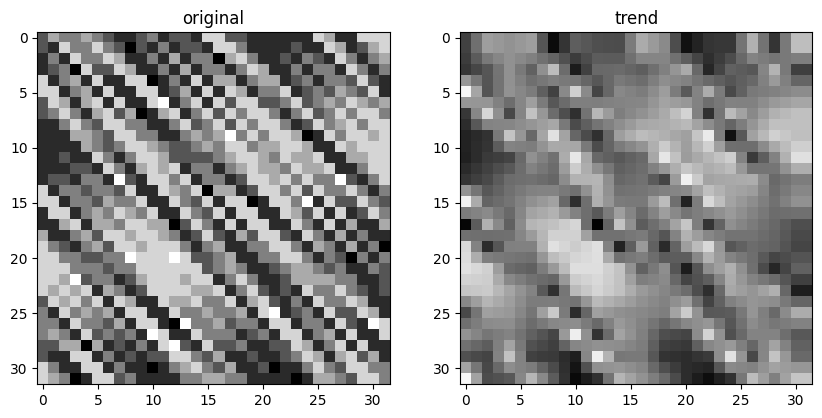

In [ ]:
coeff_zigzag_masked = np.zeros_like(coeff_zigzag)
coeff_zigzag_masked[-N_ROW//2:,:N_COL//2] = coeff_zigzag[-N_ROW//2:,:N_COL//2]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(x_zigzag, cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(idaub_5_3_lift_2D(coeff_zigzag_masked, int_flag=False), cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[1].set_title('trend')
plt.show()

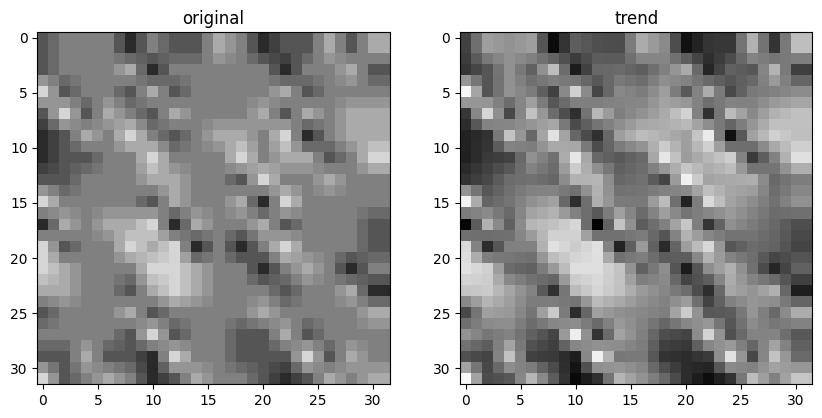

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(x_compr_2D_zg[N_FIG], cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(idaub_5_3_lift_2D(coeff_zigzag_masked, int_flag=False), cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[1].set_title('trend')
plt.show()

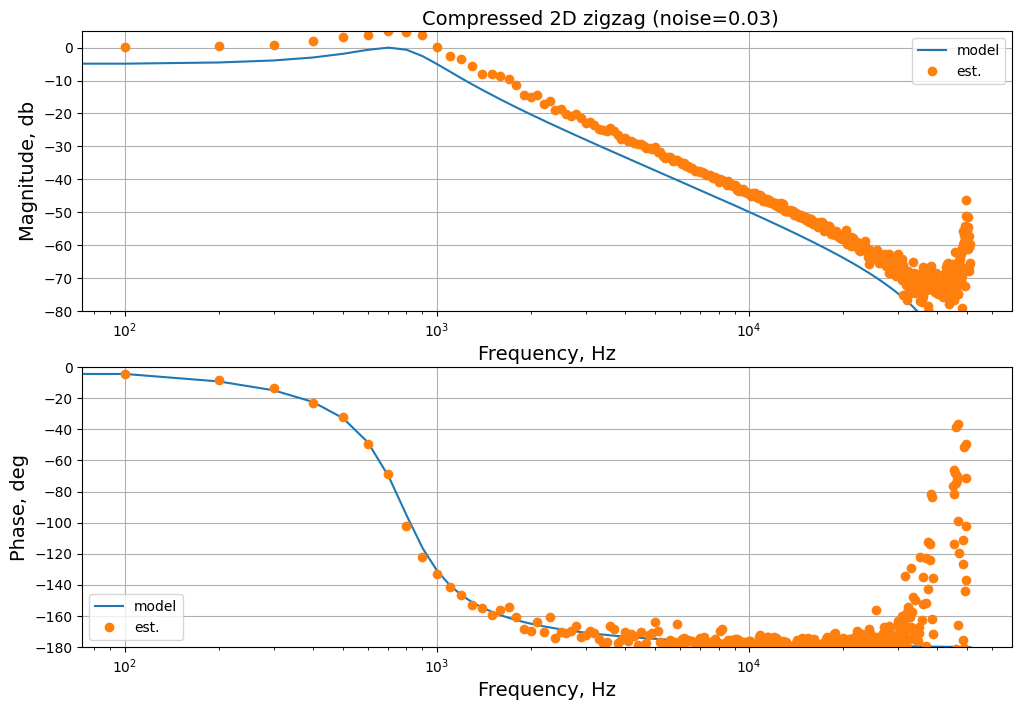

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr_2D_zg):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(900, 220, 'Compressed 2D zigzag (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

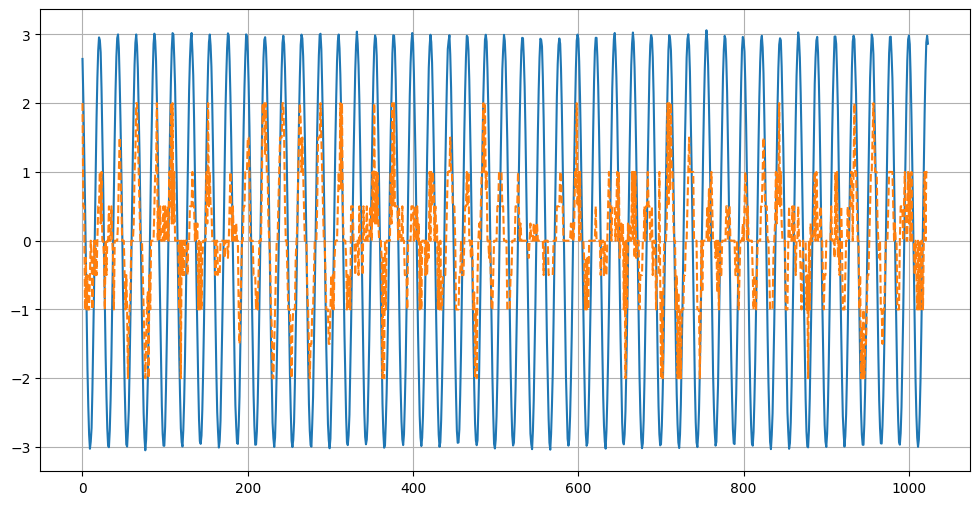

In [ ]:
plt.figure(figsize=user_figsize)
plt.plot(x[N_FIG][-N_FFT:])
plt.plot(x_compr_2D_zg_rev[N_FIG], '--')
plt.grid()
plt.show()

In [ ]:
N_FREQ = 40
# Bar width and positions
width = 1.0
x_pos = np.arange(len(freq[:N_FREQ]))

plt.bar(x_pos - width/2, np.abs(Xfft[:N_FREQ]), width, label='x', alpha=0.7)
plt.bar(x_pos + width/2, np.abs(Yfft[:N_FREQ]), width, label='y', alpha=0.7)

plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.title('FFT Comparison - Side-by-Side Bars')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'Xfft' is not defined

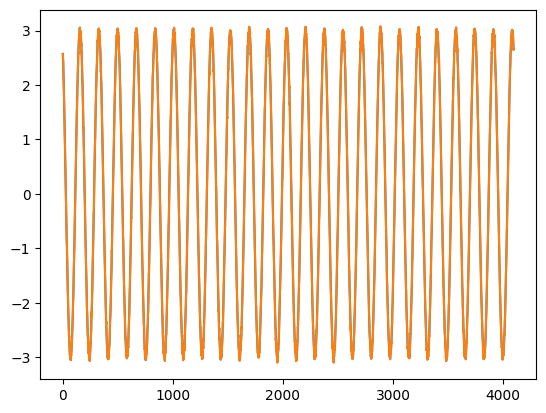

0.0


In [ ]:
x_tmp = x[5].reshape(32, -1)
x_rec = x_tmp.ravel()
print(np.sum((x[5]-x_rec)**2))
plt.plot(x[5])
plt.plot(x_rec)
plt.show()
